In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2

In [52]:
# Finds largest contour within bounding box
def findROIContour(thresh, bbox):
    bbox = map(int, bbox)
    x, y, w, h = bbox
    # ROI based off bounding box coordinates
    thresh_roi = thresh[y:y+h, x:x+w]
    # Mask of black pixels so only ROI is searched for contour
    mask = np.zeros((thresh.shape[0], thresh.shape[1]), np.uint8)
    mask[y:y+h, x:x+w] = thresh_roi
    
    # Taken from: https://stackoverflow.com/questions/54615166/find-the-biggest-contour-opencv-python-getting-errors
    contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contour_areas = [(cv2.contourArea(contour), contour) for contour in contours[0]]
    # If no contour, return None
    #print(contour_areas)
    if contour_areas is None or len(contour_areas)==0:
        final_c = [None, None]
    else:
        final_c = max(contour_areas, key=lambda x: x[0]) # Find largest contour in box
    return final_c[1]

# Find Centre coordinates of contour
def getContourMoment(contour):
    m = cv2.moments(contour)
    # Find Contour centre 
    x = m['m10'] / m['m00']
    y = m['m01'] / m['m00']
    return int(x), int(y) 

# Finds the full contour based on bounding box ROI
def findFullContour(thresh, centre):
    x, y = centre
    # Find all contours in image
    contours = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    # Return contour that centre belongs to
    for c in contours[0]:
        dist = cv2.pointPolygonTest(c, (x,y), False)
        if dist == 1.0:
            final_contour = c
            #print('Contour Found')
            #if cv2.contourArea(c) > size * 1.5:
            #    pass
            break
        else:
            final_contour = findROIContour(thresh, (x-10, y-10, 20, 20))
    #print(final_contour)
    return final_contour

# Fits a bounding box tightly around the contour
def getFittedBox(contour):
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    return rect, box

# Converts a fitted bounding box to a straight one with no rotation 
def rotatedBoxConverter(box):
    box_t = np.array(box).T
    x, y = min(box_t[0]), min(box_t[1])
    w, h = max(box_t[0]) - x, max(box_t[1]) - y
    return x, y, w, h

# Calculate avg area of box
def avgArea(box, total, count):
    x, y, w, h = box
    total += w * h
    avg = total / count
    return total, avg




### Remove Duplicates

In [53]:
waggle_df = pd.read_pickle('WaggleDetections-Bees10.pkl')
#waggle_df.drop(['index'], axis=1, inplace=True)
#waggle_df.reset_index(inplace=True)
# Sort by cluster and then frame so the dataset is ordered in blocks of clusters
waggle_df = waggle_df.sort_values(by=['Cluster', 'frame']).reset_index().drop(['index'], axis=1)

In [54]:
waggle_df

,x,y,frame,size,contour,Cluster
0,1069,259,1,499.5,"[[[1049, 221]], [[1050, 222]], [[1051, 223]], ...",0
1,1076,261,2,405.0,"[[[1070, 233]], [[1069, 234]], [[1069, 235]], ...",0
2,1041,250,2,443.0,"[[[1028, 233]], [[1027, 234]], [[1026, 235]], ...",0
3,1068,257,3,347.5,"[[[1053, 222]], [[1054, 223]], [[1055, 224]], ...",0
4,1079,255,4,249.0,"[[[1070, 233]], [[1069, 234]], [[1068, 234]], ...",0
...,...,...,...,...,...,...
14448,1227,513,13611,298.0,"[[[1220, 486]], [[1221, 486]], [[1222, 487]], ...",511
14449,1202,495,13611,435.0,"[[[1193, 474]], [[1193, 475]], [[1194, 476]], ...",511
14450,1213,504,13612,920.0,"[[[1214, 465]], [[1213, 466]], [[1212, 466]], ...",511
14451,1200,493,13613,240.5,"[[[1217, 465]], [[1216, 466]], [[1215, 466]], ...",511


In [55]:
# All rows duplicated on frame and cluster
dup = waggle_df[waggle_df.duplicated(subset=['frame', 'Cluster'], keep=False)] # Returns all rows that match on frame and cluster
dup

# All non duplicated rows
non_dup = waggle_df[~waggle_df.duplicated(subset=['frame', 'Cluster'], keep=False)] # Returns all rows that match on frame and cluster

In [56]:
a = dup.index.values
b = dup.index.values - 1 # Rows before duplicate
c = dup.index.values + 1 # Rows after duplicate

# Concatenate removing duplicate indices
idx = np.unique(np.concatenate((a, b, c)))

df = waggle_df[waggle_df.index.isin(idx)].reset_index().reset_index()
df['Cluster'].value_counts()
df.head(10)

,level_0,index,x,y,frame,size,contour,Cluster
0,0,0,1069,259,1,499.5,"[[[1049, 221]], [[1050, 222]], [[1051, 223]], ...",0
1,1,1,1076,261,2,405.0,"[[[1070, 233]], [[1069, 234]], [[1069, 235]], ...",0
2,2,2,1041,250,2,443.0,"[[[1028, 233]], [[1027, 234]], [[1026, 235]], ...",0
3,3,3,1068,257,3,347.5,"[[[1053, 222]], [[1054, 223]], [[1055, 224]], ...",0
4,4,7,1078,237,7,239.0,"[[[1072, 224]], [[1071, 225]], [[1071, 226]], ...",0
5,5,8,1037,247,9,358.5,"[[[1052, 226]], [[1051, 227]], [[1050, 227]], ...",0
6,6,9,1075,243,9,689.5,"[[[1058, 210]], [[1057, 211]], [[1056, 212]], ...",0
7,7,10,1075,254,10,627.0,"[[[1074, 231]], [[1073, 232]], [[1073, 233]], ...",0
8,8,11,1051,232,10,296.0,"[[[1058, 210]], [[1057, 211]], [[1056, 212]], ...",0
9,9,12,1077,253,11,555.0,"[[[1074, 231]], [[1073, 232]], [[1073, 233]], ...",0


In [57]:
# level_0 used for the below indexing, 'index' used for returning these values in df
pts = df[['level_0', 'x','y', 'index', 'frame']].values

#pts = pts[np.argsort(pts[:, -1], axis = 0)]    # to sort about last column if not sorted
# Returns indices of duplicates
same_pts = [np.argwhere(i[0] == pts[:, -1]) for i in np.array(np.unique(pts[:, -1], return_counts=True)).T if i[1]>=2]
save_row = []
for i in same_pts:
    dist = []
    pre = min(i)-1
    for j in i:
        # Euclidean distance between the previous point and each duplicate point
        dist_pre = np.sqrt((pts[pre, 1]-pts[j, 1])**2 + (pts[pre, 2]-pts[j, 2])**2)
        dist.append(dist_pre)
    # Save level_0 of point with the shortest distance
    save_row.append(i[np.argmin(dist)][0])
# Return points of shortest distance based on index
final_pts = pts[[save_row]]

C:\Users\jreec\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [58]:
# Concatenate final_pts index with non_duplicate index, removing unique values
final_idx = np.unique(np.concatenate((non_dup.index.values, final_pts[:, 3])))
final_idx

array([    0,     1,     3, ..., 14450, 14451, 14452], dtype=int64)

In [59]:
waggle_df = waggle_df.reset_index()
# Return all rows where index is in fnal_idx
df = waggle_df[waggle_df['index'].isin(final_idx)]

In [60]:
# Check all duplicates removed
dup = df[df.duplicated(subset=['frame', 'Cluster'], keep=False)]
dup

,index,x,y,frame,size,contour,Cluster


In [61]:
df

,index,x,y,frame,size,contour,Cluster
0,0,1069,259,1,499.5,"[[[1049, 221]], [[1050, 222]], [[1051, 223]], ...",0
1,1,1076,261,2,405.0,"[[[1070, 233]], [[1069, 234]], [[1069, 235]], ...",0
3,3,1068,257,3,347.5,"[[[1053, 222]], [[1054, 223]], [[1055, 224]], ...",0
4,4,1079,255,4,249.0,"[[[1070, 233]], [[1069, 234]], [[1068, 234]], ...",0
5,5,1090,272,5,196.5,"[[[1086, 260]], [[1085, 261]], [[1085, 262]], ...",0
...,...,...,...,...,...,...,...
14447,14447,1220,510,13606,330.5,"[[[1230, 489]], [[1230, 490]], [[1229, 491]], ...",511
14448,14448,1227,513,13611,298.0,"[[[1220, 486]], [[1221, 486]], [[1222, 487]], ...",511
14450,14450,1213,504,13612,920.0,"[[[1214, 465]], [[1213, 466]], [[1212, 466]], ...",511
14451,14451,1200,493,13613,240.5,"[[[1217, 465]], [[1216, 466]], [[1215, 466]], ...",511


There are still outliers where the euclidean distance is much greater than the average. These are likely to be errors from the clustering and should be removed

C:\Users\jreec\Anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\jreec\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


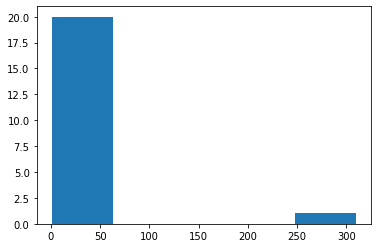

In [62]:
clust = df[df['Cluster']==10]
clust.loc[:, 'euclid'] = np.sqrt(np.square(df['x'] - df['x'].shift(1)) + np.square(df['y'] - df['y'].shift(1)))
plt.hist(clust.euclid, bins=5);

In [63]:
for i in list(df['Cluster'].unique()):
    clust = df[df['Cluster']==i]
    clust.loc[:, 'euclid'] = np.sqrt(np.square(df['x'] - df['x'].shift(1)) + np.square(df['y'] - df['y'].shift(1)))
    df.loc[clust.index, 'euclid'] = clust['euclid']

In [64]:
# Fill NaNs (first of each cluster) with 0 
df.fillna(0, inplace=True)

C:\Users\jreec\Anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


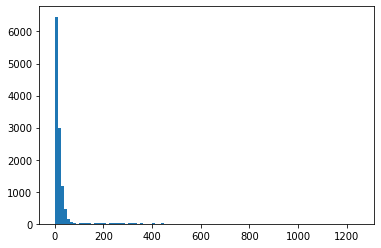

In [65]:
plt.hist(df.euclid, bins=100);

Remove data above 90% quantile as it's likely to be an outlier. Median falls within the first bin, therefore the data is greatly skewed.

In [66]:
df.euclid.max(), df.euclid.median(), df.euclid.quantile(0.9)

(1250.2007838743343, 11.045361017187261, 37.0)

In [67]:
quant = df.euclid.quantile(0.9)
df = df[df['euclid'] < quant]
df

,index,x,y,frame,size,contour,Cluster,euclid
0,0,1069,259,1,499.5,"[[[1049, 221]], [[1050, 222]], [[1051, 223]], ...",0,0.000000
1,1,1076,261,2,405.0,"[[[1070, 233]], [[1069, 234]], [[1069, 235]], ...",0,7.280110
3,3,1068,257,3,347.5,"[[[1053, 222]], [[1054, 223]], [[1055, 224]], ...",0,8.944272
4,4,1079,255,4,249.0,"[[[1070, 233]], [[1069, 234]], [[1068, 234]], ...",0,11.180340
5,5,1090,272,5,196.5,"[[[1086, 260]], [[1085, 261]], [[1085, 262]], ...",0,20.248457
...,...,...,...,...,...,...,...,...
14447,14447,1220,510,13606,330.5,"[[[1230, 489]], [[1230, 490]], [[1229, 491]], ...",511,13.892444
14448,14448,1227,513,13611,298.0,"[[[1220, 486]], [[1221, 486]], [[1222, 487]], ...",511,7.615773
14450,14450,1213,504,13612,920.0,"[[[1214, 465]], [[1213, 466]], [[1212, 466]], ...",511,16.643317
14451,14451,1200,493,13613,240.5,"[[[1217, 465]], [[1216, 466]], [[1215, 466]], ...",511,17.029386


In [68]:
df[df['Cluster']==0]

,index,x,y,frame,size,contour,Cluster,euclid
0,0,1069,259,1,499.5,"[[[1049, 221]], [[1050, 222]], [[1051, 223]], ...",0,0.000000
1,1,1076,261,2,405.0,"[[[1070, 233]], [[1069, 234]], [[1069, 235]], ...",0,7.280110
3,3,1068,257,3,347.5,"[[[1053, 222]], [[1054, 223]], [[1055, 224]], ...",0,8.944272
4,4,1079,255,4,249.0,"[[[1070, 233]], [[1069, 234]], [[1068, 234]], ...",0,11.180340
5,5,1090,272,5,196.5,"[[[1086, 260]], [[1085, 261]], [[1085, 262]], ...",0,20.248457
6,6,1088,272,6,202.0,"[[[1086, 259]], [[1085, 260]], [[1085, 261]], ...",0,2.000000
7,7,1078,237,7,239.0,"[[[1072, 224]], [[1071, 225]], [[1071, 226]], ...",0,36.400549
9,9,1075,243,9,689.5,"[[[1058, 210]], [[1057, 211]], [[1056, 212]], ...",0,6.708204
10,10,1075,254,10,627.0,"[[[1074, 231]], [[1073, 232]], [[1073, 233]], ...",0,11.000000
13,13,1053,250,11,496.0,"[[[1051, 224]], [[1050, 225]], [[1049, 225]], ...",0,22.360680


In [69]:
name = 'Bees10'

In [70]:
df.to_pickle('WaggleDetections-{}-Cleaned.pkl'.format(name))

### Fill Missing

In [71]:
# Prevent tracking update failures
def anchorBox(box, prev_box, avg):
    global counter
    x0, y0, w0, h0 = prev_box
    x, y, w, h = box
    
    # If bounding box is too far from previous box
    #if abs(x - x0) > w0/2 and abs(y - y0) > h0/2:
    if abs(x - x0) > w0/3 or abs(y - y0) > h0/3: # CHANGED FOR TESTING ON BEES10 2
        print('Box Lost')
        success = False
    # If bounding box is too large
    elif abs(w * h) > (avg * 2):
        print('Box Lost (Expanded)')
        print(str(counter))
        success = 'Expanded'
    # If bounding box is too small
    elif abs(w * h) < (avg / 1.5):
        print('Box Lost (Shrunk)')
        print(str(counter))
        success = 'Shrunk'
    # prev_box only updated if box found
    else:
        print('Box Found')
        prev_box = box 
        success = True

    return success, prev_box

def expandBox(img, bbox):
    contour = None
    x, y, w, h = bbox
    x -= 10
    w += 20
    y -= 10
    h += 20
    bbox = (x, y, w, h)
    print(bbox)
    contour = findROIContour(img, bbox)
    return bbox, contour

# Find which way object is facing by the direction in which bounding box moves, to be coupled with angle of bounding rect
def moveDirection(prev_bbox, bbox):
    x, y, w, h = bbox
    x0, y0, w0, h0 = prev_bbox
    
    xd = x - x0
    # if xd is negative, moved west, if xd is positive, moved east
    yd = y - y0
    # if yd is negative, moved north, if yd is positive, moved south
    movement = (xd, yd)
    return movement

def erodeAroundROI(frame, bbox):
    x, y, w, h = bbox
    save = frame[y:y+h, x:x+w]
    kerenl = np.ones(3,3, np.uint8)
    frame = cv2.erode(frame, kernel, iterations = 3)

def createMask(img):
    mask = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)
    mask.fill(255)
    return mask

In [72]:
final_df = pd.DataFrame(columns=['x', 'y', 'frame', 'bbox', 'size', 'angle', 'cluster']) # maybe add direction change?

'Motion vector calculation here'

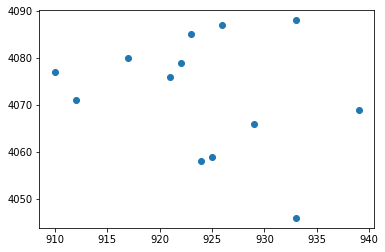

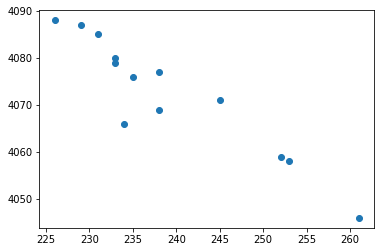

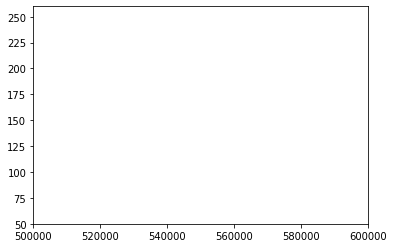

In [250]:
clust = df[df['Cluster']==185] # 1, 6, 35, 72 (didn't work, also not a waggle), 75, 222, 245 (also not a waggle)
# 6 doesn't work. Loses it when it crosses the white lime
# 1 fixed by changing the 'contour is none' code to thresh within the roi
# 100 is an example where the last two frames are wrong
# 0 has some problems at end 
clust
cap = cv2.VideoCapture('../Bees10.mov')
cap.set(1, 233)
_, frame = cap.read()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]

# plt.figure(figsize=(20,20))
# plt.imshow(thresh)
# plt.plot(1225-15, 315-15, marker='o', markersize=12)
# plt.plot(1225+15, 315+15, marker='s', markersize=12)

plt.figure()
plt.scatter(clust.x, clust.frame)
plt.figure()
plt.scatter(clust.y, clust.frame)
plt.figure()
plt.scatter(clust.x*clust.y, clust.frame)
plt.xlim(500000,600000)
plt.ylim(50, 260)

"""Motion vector calculation here"""

https://datascience.stackexchange.com/questions/41934/obtaining-a-confidence-interval-for-the-prediction-of-a-linear-regression
Use confidence interval estimate to get the area it could be in?

https://stackoverflow.com/questions/56510287/multiple-output-regression-or-classifier-with-one-or-more-parameters-with-pyth
multiple outputs 

or: trilinear interpolation
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RegularGridInterpolator.html


In [251]:
clust

,index,x,y,frame,size,contour,Cluster,euclid
5185,5185,933,261,4046,331.0,"[[[936, 242]], [[936, 243]], [[937, 244]], [[9...",185,3.605551
5190,5190,924,253,4058,322.0,"[[[931, 233]], [[932, 234]], [[933, 235]], [[9...",185,12.041595
5191,5191,925,252,4059,281.5,"[[[931, 233]], [[930, 234]], [[929, 234]], [[9...",185,1.414214
5192,5192,929,234,4066,374.0,"[[[910, 219]], [[909, 220]], [[908, 221]], [[9...",185,18.439089
5195,5195,939,238,4069,326.0,"[[[929, 219]], [[929, 220]], [[929, 221]], [[9...",185,10.770330
5198,5198,912,245,4071,189.5,"[[[904, 230]], [[905, 231]], [[906, 232]], [[9...",185,27.892651
5199,5199,921,235,4076,220.0,"[[[925, 216]], [[924, 217]], [[924, 218]], [[9...",185,13.453624
5200,5200,910,238,4077,233.0,"[[[909, 217]], [[909, 218]], [[908, 219]], [[9...",185,11.401754
5201,5201,922,233,4079,743.0,"[[[926, 211]], [[925, 212]], [[924, 212]], [[9...",185,13.000000
5202,5202,917,233,4080,567.0,"[[[927, 211]], [[926, 212]], [[927, 213]], [[9...",185,5.000000


In [261]:
clust = df[df['Cluster']==127]
# remove the vaue at frame 177 to test
evaluate = (1219, 439, 177) # x,y,z

x = np.linspace(clust.x.min(), clust.x.max(), 200)
y = np.linspace(clust.y.min(), clust.y.max(), 200)
z = np.linspace(clust.frame.min(), clust.frame.max(), 200)

from scipy import interpolate

# fx = interpolate.interp1d(z, x, kind='linear')
# fy = interpolate.interp1d(z, y, kind='linear')

fx = interpolate.interp1d(clust.frame, clust.x, kind='slinear')
fy = interpolate.interp1d(clust.frame, clust.y, kind='slinear')

# fx(179), fy(179)
# plt.plot(clust.x, clust.frame)
# plt.scatter(fx(177), 177, color='g')
# plt.figure()
# plt.plot(clust.y, clust.frame)
# plt.scatter(fy(177), 177)

# fx(177), fy(177)


In [262]:
counter = clust.iloc[0, :]['frame'] - 1

cap = cv2.VideoCapture('../Bees10.mov')
cap.set(1, counter+1)

while True:
    counter += 1
    ret, frame = cap.read()
    
    x, y = fx(counter), fy(counter)
    
    x0, x1 = x-30, x+30
    y0, y1 = y-30, y+30
    
    p1 = int(x0), int(y0)
    p2 = int(x1), int(y1)
    
    cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)    
    
    cv2.imshow('frame', frame)
    cv2.waitKey(200)
    
    if counter > clust.iloc[-1, :]['frame']-1:
        break

cv2.destroyAllWindows()
cap.release()

In [194]:
p1

(1194.0, 420.0)

In [139]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
data = clust[['x', 'y', 'frame']]
# x = data.drop('frame', axis=1).values
# y = data['frame'].values
# lr.fit(x, y)
# lr.intercept_, lr.coef_

from scipy.interpolate import RegularGridInterpolator

from numpy import linspace, zeros, array
from scipy.interpolate import interpn


def value_func_3d(x, y, z):
    return 2 * x + 3 * y - z
x = data.x
y = data.y
z = data.frame
points = (x, y, z)
values = value_func_3d(*np.meshgrid(*points))
point = np.array(173)
print(interpn(points, values, point))

ValueError: The points in dimension 0 must be strictly ascending

[[[1049  518]]

 [[1049  519]]

 [[1049  520]]

 [[1048  521]]

 [[1048  522]]

 [[1048  523]]

 [[1047  524]]

 [[1046  525]]

 [[1045  525]]

 [[1044  526]]

 [[1044  527]]

 [[1044  528]]

 [[1043  529]]

 [[1044  529]]

 [[1045  529]]

 [[1046  529]]

 [[1047  529]]

 [[1048  529]]

 [[1049  529]]

 [[1049  528]]

 [[1049  527]]

 [[1049  526]]

 [[1050  525]]

 [[1050  524]]

 [[1050  523]]

 [[1051  522]]

 [[1051  521]]

 [[1051  520]]

 [[1051  519]]

 [[1051  518]]

 [[1050  518]]]
518
[[[ 83  91 100]
  [ 80  88  97]
  [ 78  86  95]
  ...
  [204 209 220]
  [204 209 220]
  [204 209 220]]

 [[ 83  91 100]
  [ 80  88  97]
  [ 79  87  96]
  ...
  [205 210 221]
  [205 210 221]
  [205 210 221]]

 [[ 83  91 100]
  [ 80  88  97]
  [ 79  87  96]
  ...
  [206 211 222]
  [206 211 222]
  [206 211 222]]

 ...

 [[100 103 108]
  [102 105 110]
  [ 99 107 111]
  ...
  [ 86 108 123]
  [ 82 107 121]
  [ 80 105 119]]

 [[107 102 108]
  [106 101 107]
  [ 99 100 105]
  ...
  [ 88 113 127]
  [ 87 1

-1

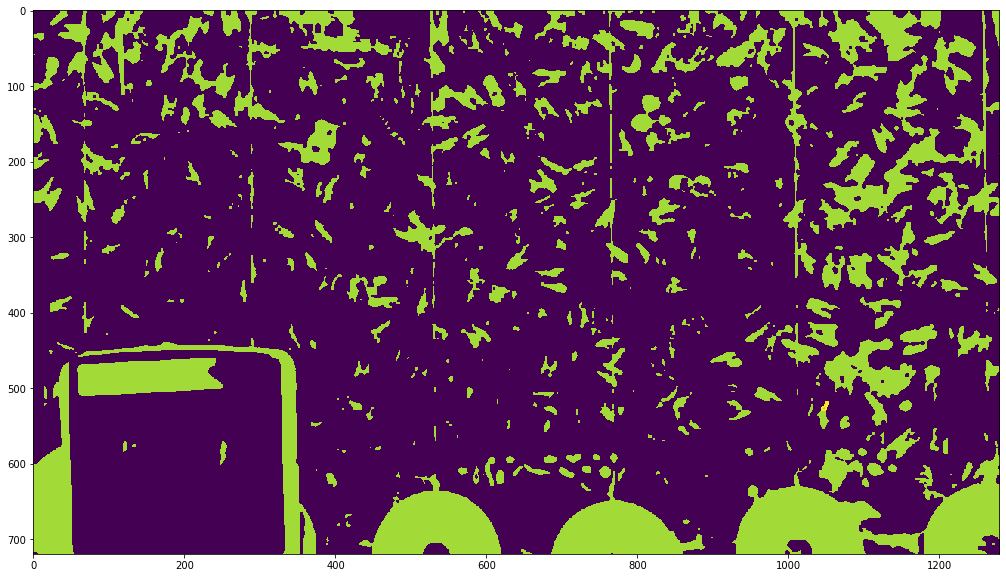

In [33]:
start = clust.iloc[0, :]['frame']
end = clust.iloc[-1, :]['frame']
cluster = clust.iloc[0, :]['Cluster']
# Get range of frames where waggle occurs
rang = np.arange(start, end, 1)
missing = list(set(rang)-set(clust.frame.values)) # Frames where waggle missing from df

counter = start
cap = cv2.VideoCapture('../Bees10.mov')
cap.set(1, start)
ret, frame = cap.read()
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Preprocessing
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh_min, thresh_max = 120, 220
thresh = cv2.threshold(gray, thresh_min, thresh_max, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
opening = cv2.erode(opening, kernel, iterations=1)

# Find contour bounding box
x, y = clust.iloc[0, :]['x'], clust.iloc[0]['y']
bbox = x-15, y-15, 30, 30

contour = findROIContour(opening, bbox)
print(contour)
if contour is None:
    print('Contour None')
    contour = findROIContour(thresh, bbox)
    opening = thresh # For findFullContour
plt.figure(figsize=(20,10))
cv2.drawContours(opening, contour, -1, (255,0,0), 2, 1)
plt.imshow(opening)
centre = getContourMoment(contour)
contour = findFullContour(opening, centre)
if cv2.contourArea(contour) > clust['size'].max():
    contour = findROIContour(opening, bbox)
    print(contour)
rect, box = getFittedBox(contour)
bbox = rotatedBoxConverter(box)
prev_bbox = bbox
found = True
avg = bbox[2]*bbox[3]
total = avg
print(avg)

# Create tracker 
print(frame)
tracker = cv2.TrackerCSRT_create()
tracker.init(frame, bbox)

rois = []

while counter < end:
    counter += 1 
    print(counter)
    nret, frame = cap.read()
    
    # Preprocessing
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (15,15), 1)
    thresh = cv2.threshold(gray, thresh_min, thresh_max, cv2.THRESH_BINARY)[1]
    kernel = np.ones((2,2),np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    opening = cv2.erode(opening, kernel, iterations=1)
    
    if counter not in missing:
        print('In DF')
        waggle = clust[clust['frame']==counter].reset_index()
        x, y = waggle.loc[0, 'x'], waggle.loc[0, 'y']
        bbox = x-15, y-15, 30, 30
        print(prev_bbox, bbox)
        # If found is false, either false positive in detection DF or false positive in previous frame
        found, prev_bbox = anchorBox(bbox, prev_bbox, avg)
        
    # If frame not in df, use tracker to fill in the missing
    if counter in missing:
        print('Missing')
        bbox = prev_bbox[0] - 5, prev_bbox[1] - 5, prev_bbox[2] + 10, prev_bbox[3] + 10
        print(prev_bbox, bbox)
    
    # If bbox goes out of frame, end tracking 
    if bbox[0] < 0 or bbox[0] > width or bbox[1] < 0 or bbox[1] > height:
        print('Object out of bounds')
        final_df.loc[len(final_df)] = 0
        break        
    
    
    # FIX needed here to prevent jumping
    """ Current idea: Degrade around the outside + 10 of prev_bbox, then use prev_bbox + 5 for Contour detection.
        Found needs to be checked for 'missing' too."""
    """ Get vector of general forward motion of this waggle (average?), if bounding box not moving 
        in this direction, move prev_bbox in that direction"""

    """ turn below into a function"""
    # Erode outside bounding box, no operation inside the bounding box
    save = opening[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
    opening = cv2.erode(opening, kernel, iterations=3)
    opening[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]] = save

    
    # Find contour from bbox. If None, lower threshold inside the bounding box
    contour = findROIContour(opening, bbox)
    if contour is None:
        print('Contour None')
        contour = findROIContour(thresh, bbox)
        opening = thresh # For findFullContour
    # If contour still None, dilate
    low = thresh_min
    while contour is None or cv2.contourArea(contour) <= 80: # or too small
        print('Contour still none')
        low -= 5
        thresh = cv2.threshold(gray, low, thresh_max, cv2.THRESH_BINARY)[1]
        opening[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]] = thresh[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
        contour = findROIContour(opening, bbox)
        #opening = dilate # For findFullContour

    roi_contour = contour # Save for use in findFullContour failure
    # Readjust centre and find full contour outside ROI
    centre = getContourMoment(contour)
    bbox = centre[0]-15, centre[1]-15, 30, 30
    contour = findROIContour(opening, bbox)
#     contour = findFullContour(opening, centre)
#     # If contour too large, erode image, then use ROI
#     while cv2.contourArea(contour) > clust['size'].max():
#         opening = cv2.erode(opening, kernel, iterations = 1)
#         bbox = centre[0]-15, centre[1]-15, 30, 30
#         contour = findROIContour(opening, bbox)
#         if contour is None:
#             print('Using previous ROI contour')
#             contour = roi_contour
#             break
    rect, box = getFittedBox(contour)
    bbox = rotatedBoxConverter(box)
    
    found, prev_bbox = anchorBox(bbox, prev_bbox, avg)
    
    if found is not True:
        print('Found is False')
        contour = roi_contour
        centre = getContourMoment(contour)
        bbox = centre[0]-15, centre[1]-15, 30, 30
        contour = findROIContour(opening, bbox)
        rect, box = getFittedBox(contour)
        bbox = rotatedBoxConverter(box)
    
    """ This probably needs changing """
    if bbox[2]*bbox[3] > avg*1.5:
        print('Too Large')
        # Re-centre ROI to contour, and get bbox on cropped contour
        x, y = centre 
        bbox = x-15, y-15, 30, 30
        contour = findROIContour(opening, bbox)
        rect, box = getFittedBox(contour)
        print(rect[-1])
        bbox = rotatedBoxConverter(box)
    
    angle = rect[-1]
    size = cv2.contourArea(contour)
        
    print(bbox)
    # VISUALS    
    if ret:
    # Tracking success
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)
        cv2.rectangle(opening, p1, p2, (255, 0, 0), 2, 1)
    else:
        cv2.putText(frame, "Tracking failure detected", (100, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    cv2.imshow("Tracking", frame)
    cv2.imshow("Threshold", opening)
    cv2.waitKey(100)
    if found is not True:
        if cv2.waitKey(0) & 0xFF == ord('c'):
            pass
    
    euclid = np.sqrt(np.square(centre[0] - prev_centre[0]) + np.square(centre[1] - prev_centre[1]))
    
    final_df.loc[len(final_df)] = [centre[0], centre[1], counter, bbox, size, angle, cluster]
    
    movement = moveDirection(prev_bbox, bbox) # Track direction of box movement
    prev_centre = centre
    prev_bbox = bbox
    total, avg = avgArea(bbox, total, (counter-start)) # Track avg size of bounding box

    
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

In [ ]:
bbox
cap = cv2.VideoCapture('../Bees10.mov')
cap.set(1, 6)
ret, frame = cap.read()

# Preprocessing
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
opening = cv2.erode(opening, kernel, iterations=1)
dilate = cv2.dilate(opening, kernel, iterations=5)
dilate = cv2.threshold(gray, 100, 220, cv2.THRESH_BINARY)[1]
opening[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]] = dilate[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]


p1 = (int(bbox[0]), int(bbox[1]))
p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
cv2.rectangle(thresh, p1, p2, (255, 0, 0), 2, 1)
plt.figure(figsize=(20,20))
plt.imshow(thresh)

In [ ]:
dilate[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]

In [44]:
21
In DF
(1061, 219, 28, 29) (1035, 222, 30, 30)
Box Lost
Contour still none
(1055, 233)
Box Lost
Found is False
(1046, 218, 23, 29)
22
Missing
(1046, 218, 23, 29) (1041, 213, 33, 39)
(1061, 226)
Box Found
(1046, 211, 29, 29)
23
In DF
(1046, 211, 29, 29) (1027, 208, 30, 30)
Box Lost
(1042, 218)
Box Lost
Found is False
(1026, 205, 33, 25)

SyntaxError: invalid syntax (<ipython-input-44-5f4ba6dc9dca>, line 1)

In [153]:
clust[clust['frame']==21]
# bbox = 1184, 313, 40, 25
# prev_bbox = bbox
# bbox = prev_bbox[0] - 5, prev_bbox[1] - 5, prev_bbox[2] + 10, prev_bbox[3] + 10
bbox = 1050-15, 237-15, 30, 30
bbox = 1061, 219, 28, 29

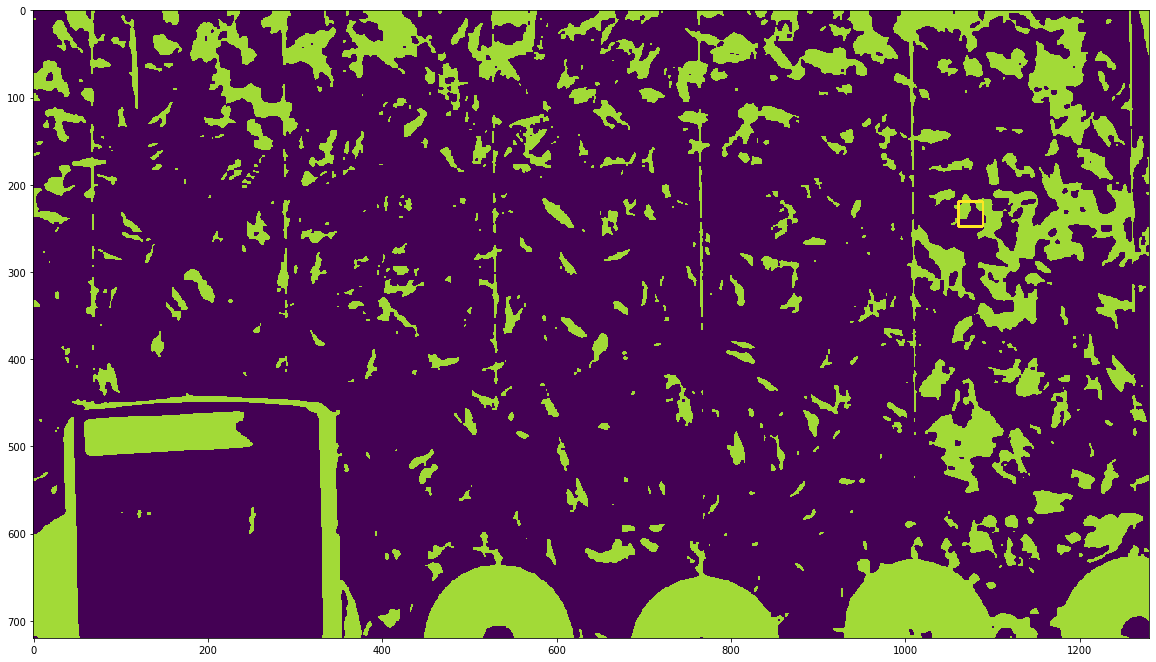

In [154]:
cap = cv2.VideoCapture('../Bees10.mov')
cap.set(1, 21)
ret, frame = cap.read()

# Preprocessing
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
opening = cv2.erode(opening, kernel, iterations=1)

p1 = (int(bbox[0]), int(bbox[1]))
p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
cv2.rectangle(opening, p1, p2, (255, 0, 0), 2, 1)
plt.figure(figsize=(20,20))
plt.imshow(opening)



In [88]:
final_df[final_df['cluster']==72]

,x,y,frame,bbox,size,angle,cluster
989,1188,303,3050,"[[1202, 317], [1173, 317], [1173, 288], [1202,...",841.0,-90.000000,72
990,1171,304,3051,"[[1158, 315], [1155, 289], [1173, 287], [1176,...",209.0,-6.340192,72
991,1159,283,3052,"[[1171, 297], [1144, 297], [1144, 268], [1171,...",361.0,-90.000000,72
992,1155,272,3053,"[[1169, 286], [1140, 286], [1140, 257], [1169,...",483.0,-90.000000,72
993,1184,315,3054,"[[1191, 320], [1179, 320], [1179, 311], [1191,...",86.5,-90.000000,72
...,...,...,...,...,...,...,...
1071,1239,313,3132,"[[1251, 327], [1234, 324], [1237, 300], [1254,...",284.5,-82.405357,72
1072,1244,302,3133,"[[1247, 314], [1232, 295], [1239, 289], [1255,...",123.5,-38.157227,72
1073,1241,287,3134,"[[1250, 296], [1231, 296], [1231, 277], [1250,...",234.0,-90.000000,72
1074,1240,276,3135,"[[1254, 290], [1225, 290], [1225, 261], [1254,...",691.5,-90.000000,72


In [ ]:
from math import cos, sin
cols = (len(final_df['bbox']) // 10) + 1
plt.figure(figsize=(40, 20))

for i in range(0, len(final_df['bbox'])):
    x = [final_df.loc[i, 'bbox'][0][0], final_df.loc[i, 'bbox'][1][0]]
    y = [final_df.loc[i, 'bbox'][0][1], final_df.loc[i, 'bbox'][1][1]]
    
    angle = final_df.loc[i, 'angle']
    x, y = final_df.loc[i, 'bbox'][0]
    x1, y1 = x + 50 * cos(angle), y + 50 * sin(angle)


    # Setting the values for all axes.
    plt.subplot(cols, 10, i+1)
    plt.plot((x, x1), (y, y1), linewidth=5)
    #plt.xlim(1150, 1250)
    #plt.ylim(250, 400)
    

#for box in final_df['bbox']

The above is not the perfect way of displaying angles, as it does not show the intricacies of the angles throughout the waggle run. However, something like this where it shows the gradient as either positive or negative allows us to see the frequency of the bees waggle, demonstrating the intensity of the waggle run.

~28 direction changes over 52 frames

25 FPS, = ~13.5 waggles per second 

This is in line with research that the bee waggles at 13-15Hz https://www.beeculture.com/a-closer-look-waggle-dances/#:~:text=2013

In [18]:
cap = cv2.VideoCapture('Bees10.mov')
fps = cap.get(cv2.CAP_PROP_FPS)
fps

25.0

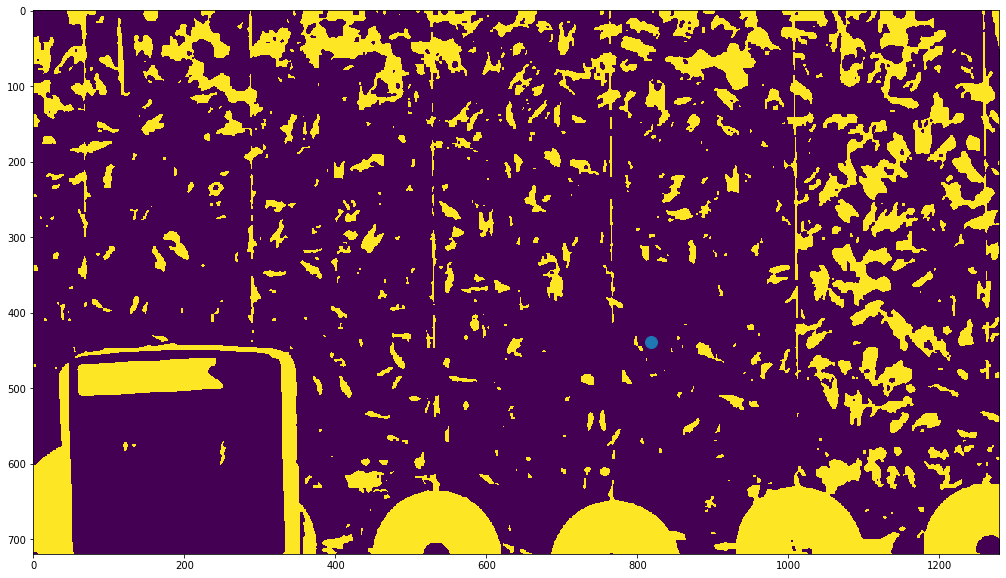

In [19]:
cap.set(1, 71)
ret, frame = cap.read()

# Preprocessing
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
#thresh = cv2.threshold(gray, 130, 220, cv2.THRESH_BINARY)[1]
thresh = cv2.threshold(gray, 120, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
opening = cv2.erode(opening, kernel, iterations=1)
#opening = cv2.dilate(thresh, kernel, iterations=2)


plt.figure(figsize=(20,10))
plt.imshow(opening)
plt.plot(818, 439, marker='o', markersize=12)

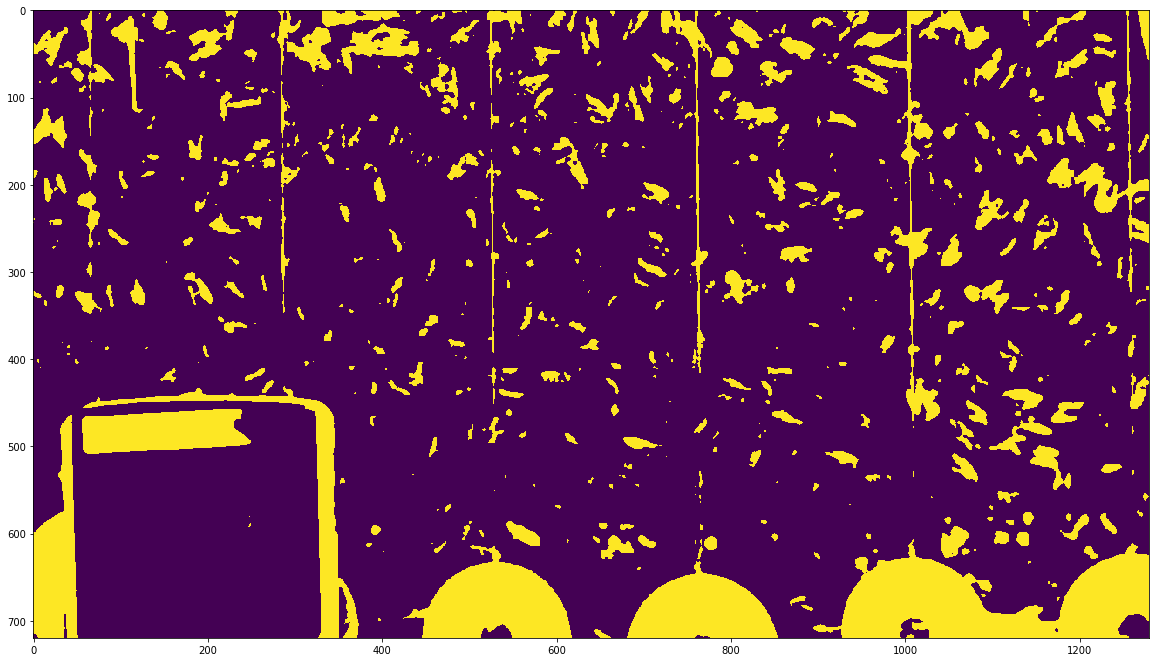

In [23]:
j = 130
# Preprocessing
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 1)
#thresh = cv2.threshold(gray, 130, 220, cv2.THRESH_BINARY)[1]
thresh = cv2.threshold(gray, j, 220, cv2.THRESH_BINARY)[1]
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
opening = cv2.erode(opening, kernel, iterations=1)
#opening = cv2.dilate(thresh, kernel, iterations=2)
plt.figure(figsize=(20,20))
plt.imshow(thresh)

(1016, 362, 30, 30)

In [87]:
waggle_df[waggle_df['Cluster'] == 2]

,index,x,y,frame,size,contour,Cluster
81,81,1087,569,60,213.5,"[[[1074, 561]], [[1074, 562]], [[1074, 563]], ...",2
82,82,1089,559,61,294.0,"[[[1091, 548]], [[1091, 549]], [[1091, 550]], ...",2
83,83,1064,562,63,207.5,"[[[1056, 551]], [[1057, 552]], [[1057, 553]], ...",2
84,84,1080,544,63,197.0,"[[[1069, 533]], [[1070, 534]], [[1070, 535]], ...",2
85,85,1075,569,67,256.0,"[[[1061, 537]], [[1061, 538]], [[1061, 539]], ...",2
86,86,1072,547,71,283.5,"[[[1065, 527]], [[1064, 528]], [[1063, 528]], ...",2
87,87,1079,558,77,289.5,"[[[1086, 537]], [[1085, 538]], [[1084, 539]], ...",2
88,88,1090,569,79,232.5,"[[[1110, 552]], [[1109, 553]], [[1108, 554]], ...",2
89,89,1075,539,79,267.0,"[[[1042, 521]], [[1042, 522]], [[1043, 523]], ...",2
90,90,1101,555,80,232.5,"[[[1093, 537]], [[1092, 538]], [[1091, 538]], ...",2


In [133]:
final_df.loc[0:63]

,x,y,frame,bbox,size,angle,cluster
0,1041,124,111,"[[1037, 138], [1032, 117], [1045, 114], [1051,...",214.5,-14.036244,6
1,1041,122,112,"[[1045, 137], [1023, 107], [1035, 98], [1056, ...",209.0,-35.837650,6
2,1032,113,113,"[[1039, 131], [1014, 100], [1024, 91], [1050, ...",238.0,-39.472462,6
3,1013,98,114,"[[1013, 101], [1010, 98], [1012, 95], [1016, 99]]",15.0,-45.000000,6
4,1011,96,115,"[[1002, 111], [997, 80], [1018, 76], [1023, 107]]",329.5,-10.784298,6
...,...,...,...,...,...,...,...
59,1053,27,170,"[[1067, 41], [1038, 41], [1038, 12], [1067, 12]]",616.0,-90.000000,6
60,1053,28,171,"[[1067, 42], [1038, 42], [1038, 13], [1067, 13]]",658.5,-90.000000,6
61,1049,28,172,"[[1063, 34], [1034, 34], [1034, 13], [1063, 13]]",554.0,-90.000000,6
62,1048,20,173,"[[1062, 34], [1033, 34], [1033, 5], [1062, 5]]",656.5,-90.000000,6


-72.21591376243754

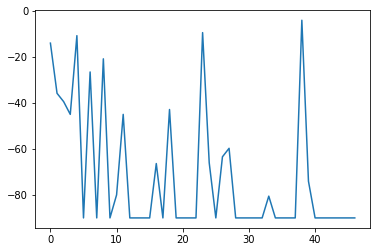

In [136]:
final_df.loc[0:46, 'angle']
plt.plot(final_df.loc[0:46, 'angle'])

final_df.loc[0:46, 'angle'].mean()

In [128]:
21/1.8 # hz

11.666666666666666

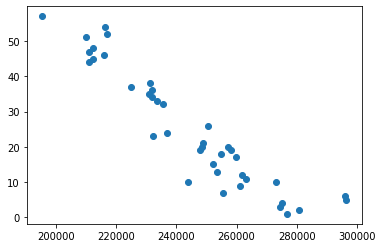

In [118]:
plt.scatter(clust.x*clust.y, clust.frame)

""
